#Istanbul Technical Univerisity
Department of Cybersecurity and İnformatics                  Term Semester 24-25

```
Prof. Dr. Ömer Faruk Tuna, PhD
BGK 520E, CRN 13653
```
```
StudentID:704231023
Student Name:Mohammad Noor İslam
```

#Introduction
This project investigates the robustness of a convolutional neural network (CNN) model trained on the Fashion MNIST dataset, a popular benchmark for image classification tasks. The objective is to train a standard model and then an adversarially robust model using adversarial training with the Fast Gradient Sign Method (FGSM). This is followed by testing the models’ resilience to attacks using the Basic Iterative Method (BIM), both in untargeted and targeted forms. Through this work, we aim to analyze the impact of adversarial training on model robustness and to quantify the effectiveness of adversarial attacks in compromising the predictive accuracy of both standard and adversarially trained models.

#Part 1. Model Training (40 Points)
#1.1. Perform Normal Model Training (10 Points)

Load the Fashion MNIST dataset. Define a CNN model suitable for Fashion MNIST.
Train the model for 30 epochs and aim for 92% accuracy on the test set. Plot the training and testing performance after each epoch. Save the model weights as normal_model.pt.

In [ ]:
#Step 1: Install and import required packages
#Step 1: Install and import required packages
!pip install torch torchvision torchattacks
#if this show errors, pls install this pip for erorr correction.

#Import the BIM attack from torchattacks
from torchattacks import BIM
import torch
import torch.nn.functional as F # import the necessary module and alias it as F
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

#Let check if the torch device cuda is available or not.
torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Load Fashion MNIST data
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

Epoch [1/30], Train Loss: 0.4490, Test Loss: 0.3474, Test Accuracy: 87.60%
Epoch [2/30], Train Loss: 0.2840, Test Loss: 0.2984, Test Accuracy: 88.83%
Epoch [3/30], Train Loss: 0.2405, Test Loss: 0.2588, Test Accuracy: 90.77%
Epoch [4/30], Train Loss: 0.2106, Test Loss: 0.2506, Test Accuracy: 90.64%
Epoch [5/30], Train Loss: 0.1855, Test Loss: 0.2488, Test Accuracy: 91.03%
Epoch [6/30], Train Loss: 0.1640, Test Loss: 0.2349, Test Accuracy: 91.72%
Epoch [7/30], Train Loss: 0.1453, Test Loss: 0.2381, Test Accuracy: 91.89%
Epoch [8/30], Train Loss: 0.1276, Test Loss: 0.2316, Test Accuracy: 92.11%
Achieved 92% accuracy, stopping early.


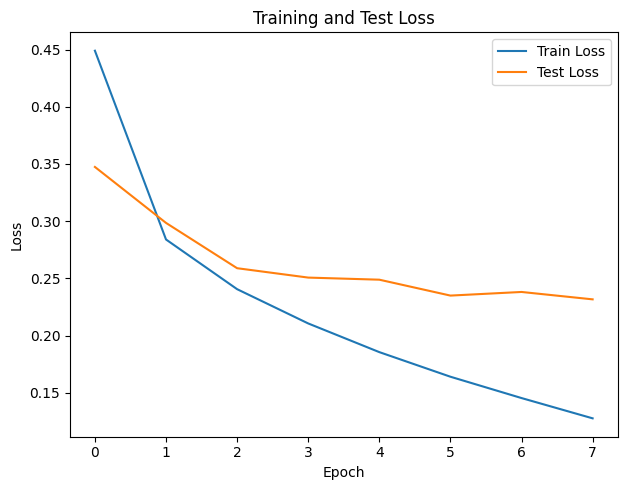

In [ ]:
#Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#Instantiate the model, loss function, and optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Train the model
epochs = 30
train_losses, test_losses = [], []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    #Test the model
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    #Record and print losses
    train_losses.append(running_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%')

    #Stop if accuracy threshold is met
    if accuracy >= 92.0:
        print("Achieved 92% accuracy, stopping early.")
        break

#Save the resulting trained model weights as normal model.pt file.
torch.save(model.state_dict(), 'normal_model.pt')

#Plot the training and test losses
plt.figure(figsize=(12, 5))

#Plot Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.tight_layout()
plt.show()


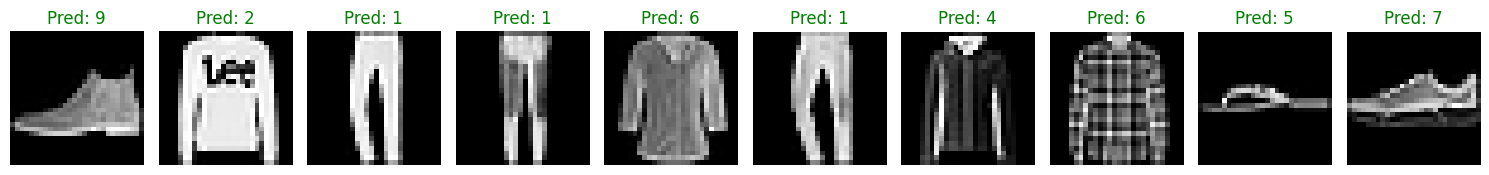

In [ ]:
#Set model to evaluation mode
model.eval()

#Get a batch of test data
data_iter = iter(test_loader)
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

#Get predictions from the model
outputs = model(images)
_, predicted = torch.max(outputs, 1)

#Plot the first 10 test images with predicted labels in green
fig, axes = plt.subplots(1, 10, figsize=(15, 4))
for i in range(10):
    ax = axes[i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')

    #Ensure title is always green
    ax.set_title(f'Pred: {predicted[i].item()}', color='green')

    ax.axis('off')  # Turn off axis for cleaner visualization
plt.tight_layout()
plt.show()


In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'normal_model.pt')

#1.2. Perform Adversarial Training (30 Points)
For adversarial training, we will: Train the CNN with FGSM (Fast Gradient Sign Method) adversarial attacks on the images. Set epsilon = 0.03 for the FGSM attack. Train the model for 35 epochs and aim for a 91% accuracy on the test set. Plot training/testing performance, visualize predictions, and save the model as robust_model.pt.



In [ ]:
#FGSM Attack Function
def fgsm_attack(model, data, target, epsilon):
    data.requires_grad = True
    output = model(data)
    loss = criterion(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = data + epsilon * data_grad.sign()
    return torch.clamp(perturbed_data, 0, 1)

In [ ]:
#Adversarial Training Loop
model_robust = CNN().to(device)
optimizer_robust = optim.Adam(model_robust.parameters(), lr=0.001)
epochs_robust = 35
epsilon = 0.03
train_losses_robust, test_losses_robust = [], []

for epoch in range(epochs_robust):
    model_robust.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        #Generate adversarial examples
        images = fgsm_attack(model_robust, images, labels, epsilon)

        #Forward pass
        outputs = model_robust(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        optimizer_robust.zero_grad()
        loss.backward()
        optimizer_robust.step()

        running_loss += loss.item()

    #Test the adversarially trained model
    model_robust.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_robust(images)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    #Record and print losses
    train_losses_robust.append(running_loss/len(train_loader))
    test_losses_robust.append(test_loss/len(test_loader))
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{epochs_robust}], Train Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {accuracy:.2f}%')

    #Stop if accuracy threshold is met
    if accuracy >= 91.0:
        print("Achieved 91% accuracy, stopping early.")
        break


Epoch [1/35], Train Loss: 0.6185, Test Loss: 0.4118, Test Accuracy: 84.11%
Epoch [2/35], Train Loss: 0.4625, Test Loss: 0.3470, Test Accuracy: 87.11%
Epoch [3/35], Train Loss: 0.4223, Test Loss: 0.3152, Test Accuracy: 88.04%
Epoch [4/35], Train Loss: 0.3974, Test Loss: 0.3053, Test Accuracy: 88.31%
Epoch [5/35], Train Loss: 0.3796, Test Loss: 0.2947, Test Accuracy: 88.69%
Epoch [6/35], Train Loss: 0.3638, Test Loss: 0.2962, Test Accuracy: 88.77%
Epoch [7/35], Train Loss: 0.3526, Test Loss: 0.2862, Test Accuracy: 88.91%
Epoch [8/35], Train Loss: 0.3414, Test Loss: 0.2753, Test Accuracy: 89.99%
Epoch [9/35], Train Loss: 0.3296, Test Loss: 0.2705, Test Accuracy: 89.74%
Epoch [10/35], Train Loss: 0.3222, Test Loss: 0.2657, Test Accuracy: 90.03%
Epoch [11/35], Train Loss: 0.3130, Test Loss: 0.2590, Test Accuracy: 90.68%
Epoch [12/35], Train Loss: 0.3048, Test Loss: 0.2685, Test Accuracy: 90.17%
Epoch [13/35], Train Loss: 0.2999, Test Loss: 0.2579, Test Accuracy: 90.55%
Epoch [14/35], Train 

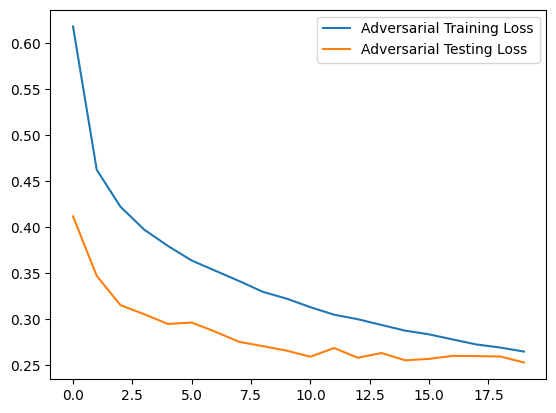

In [ ]:
#Save the adversarially trained model
torch.save(model_robust.state_dict(), 'robust_model.pt')

#Plot training and test performance
plt.plot(train_losses_robust, label='Adversarial Training Loss')
plt.plot(test_losses_robust, label='Adversarial Testing Loss')
plt.legend()
plt.show()

#Part 2. Adversarial Attacks (60 Points)
#2.1.Apply untargeted attack (30 Points)
For the untargeted attack, we’ll: Set the BIM parameters (alpha=0.002, iterations=30, epsilon=0.03). Attack both normal_model and robust_model.
Calculate the attack success rate, which is the percentage of incorrect predictions caused by the attack. Visualize 10 perturbed images with their predicted classes.


In [ ]:
# Instantiate the model and load weights for the normal model
normal_model = CNN()
normal_model.load_state_dict(torch.load("normal_model.pt"))
normal_model.eval()

# Repeat the same for the robust model
robust_model = CNN()
robust_model.load_state_dict(torch.load("robust_model.pt"))
robust_model.eval()


<ipython-input-56-bb3b77e7628d>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_model.load_state_dict(torch.load("normal_model.pt"))
<ipython-input-56-bb3b77e7628d>:

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

<ipython-input-57-550e138b5020>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  normal_model.load_state_dict(torch.load('normal_model.pt'))
<ipython-input-57-550e138b5020>:

Untargeted BIM Attack Success Rate on Normal Model: 72.56%
Untargeted BIM Attack Success Rate on Robust Model: 21.88%
Visualizing Untargeted BIM Perturbed Images (Normal Model):


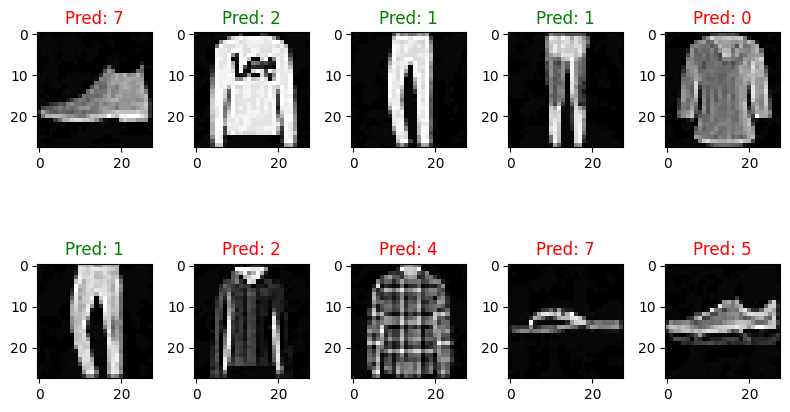

In [ ]:
#Load previously trained models
normal_model = CNN().to(device)
normal_model.load_state_dict(torch.load('normal_model.pt'))
normal_model.eval()

robust_model = CNN().to(device)
robust_model.load_state_dict(torch.load('robust_model.pt'))
robust_model.eval()

#Define BIM attack parameters
alpha = 0.002
iterations = 30
epsilon = 0.03

#Apply Untargeted BIM Attack
untargeted_bim_normal = BIM(normal_model, eps=0.03, alpha=0.002, steps=30)
untargeted_bim_robust = BIM(robust_model, eps=0.03, alpha=0.002, steps=30)

#Function to evaluate attack success rate
def attack_success_rate(model, attack, loader):
    model.eval()
    total_samples = 0
    successful_attacks = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        adv_data = attack(data, target)
        output = model(adv_data)
        pred = output.argmax(dim=1, keepdim=True)
        successful_attacks += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)
    return 100.0 * (1 - successful_attacks / total_samples)

# Evaluate Untargeted Attack Success
untargeted_success_normal = attack_success_rate(normal_model, untargeted_bim_normal, test_loader)
untargeted_success_robust = attack_success_rate(robust_model, untargeted_bim_robust, test_loader)

print(f"Untargeted BIM Attack Success Rate on Normal Model: {untargeted_success_normal:.2f}%")
print(f"Untargeted BIM Attack Success Rate on Robust Model: {untargeted_success_robust:.2f}%")

# Function to visualize perturbed images with color-coded predictions
def plot_images_with_colors(images, labels, preds):
    plt.figure(figsize=(8, 5))
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')

        # Set title color based on prediction correctness
        title_color = 'green' if labels[i] == preds[i] else 'red'
        plt.title(f"Pred: {preds[i]}", color=title_color)

        plt.axis('on')
    plt.tight_layout()
    #plt.show()

# Updated function for visualizing perturbed images
def visualize_perturbed_images(model, attack, loader):
    data_iter = iter(loader)
    data, target = next(data_iter)
    data, target = data.to(device), target.to(device)
    adv_data = attack(data, target)
    preds = model(adv_data).argmax(dim=1)

    # Call the updated plot function
    plot_images_with_colors(adv_data.cpu(), target.cpu(), preds.cpu())

# Call this for visualizing
print("Visualizing Untargeted BIM Perturbed Images (Normal Model):")
visualize_perturbed_images(normal_model, untargeted_bim_normal, test_loader)


#2.2. Apply targeted attack (30 Points)
For the targeted attack, we’ll: Use the same BIM settings but set the target class as “Dress” (class 3). Test the attack on both models. Show the attack success rate and visualize 10 perturbed images.

Targeted BIM Attack Success Rate on Normal Model: 1.06%
Targeted BIM Attack Success Rate on Robust Model: 7.85%
Visualizing Targeted BIM Perturbed Images (Robust Model):


(-0.5, 27.5, 27.5, -0.5)

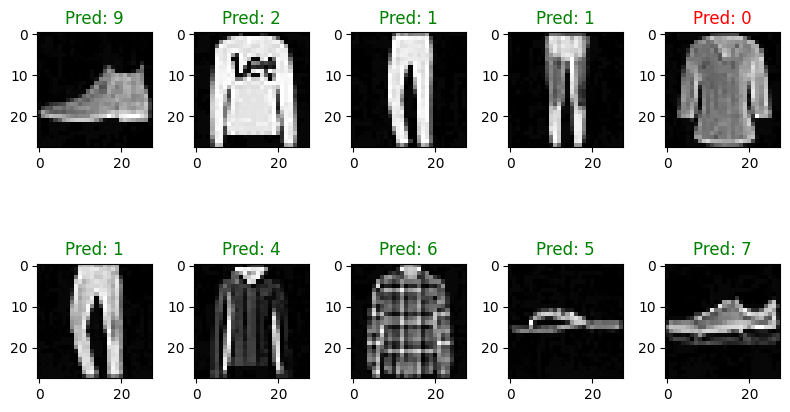

In [ ]:
#Apply Targeted BIM Attack
#Define BIM attack parameters

alpha = 0.002
iterations = 30
epsilon = 0.03

target_class = 3  # Dress
targeted_bim_normal = BIM(model=normal_model, eps=0.03, alpha=0.002, steps=30)
targeted_bim_robust = BIM(robust_model, eps=0.03, alpha=0.002, steps=30)

def targeted_attack_success(model, attack, loader, target_class):
    model.eval()
    total_samples = 0
    successful_attacks = 0
    for data, target in loader:
        data, target = data.to(device), target.to(device)
        target.fill_(target_class)  # Set target label to Dress (class 3)
        adv_data = attack(data, target)
        output = model(adv_data)
        pred = output.argmax(dim=1, keepdim=True)
        successful_attacks += pred.eq(target.view_as(pred)).sum().item()
        total_samples += target.size(0)
    return 100.0 * (successful_attacks / total_samples)

# Evaluate Targeted Attack Success
targeted_success_normal = targeted_attack_success(normal_model, targeted_bim_normal, test_loader, target_class)
targeted_success_robust = targeted_attack_success(robust_model, targeted_bim_robust, test_loader, target_class)

print(f"Targeted BIM Attack Success Rate on Normal Model: {targeted_success_normal:.2f}%")
print(f"Targeted BIM Attack Success Rate on Robust Model: {targeted_success_robust:.2f}%")

# Visualize perturbed images (Targeted Attack)
print("Visualizing Targeted BIM Perturbed Images (Robust Model):")
visualize_perturbed_images(robust_model, targeted_bim_robust, test_loader)
plt.axis('on')


#Conclusion
This project successfully implemented both normal and adversarial training approaches on a CNN model applied to the Fashion MNIST dataset, highlighting the difference in robustness between the two methods. The adversarially trained model demonstrated greater resilience to adversarial attacks, especially under the Basic Iterative Method (BIM), as compared to the normally trained model. Specifically, adversarial training with the FGSM attack was shown to significantly decrease the success rate of untargeted and targeted BIM attacks, illustrating that even simple adversarial training techniques can fortify models against certain types of adversarial perturbations.

However, the results also underscore the limitations of adversarial training. While it improved robustness, the model was not entirely impervious to attacks, suggesting the need for more advanced or hybrid defense mechanisms to counter more sophisticated adversarial strategies. Overall, this study reinforces the importance of integrating adversarial defenses in neural network training pipelines, especially for applications where model security and reliability are paramount. Future work could explore adaptive and ensemble-based methods to enhance model robustness further, ultimately contributing to the development of more secure and trustworthy AI systems.